In [1]:
import pandas as pd
import matplotlib as plt
%matplotlib inline
import seaborn
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
np.random.seed(5)
from sklearn.metrics import confusion_matrix
# Test a Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [13]:
def read_in():
    data16accel = pd.read_csv("data/16/aceleracaoLinear_terra.csv")
    data16metro = pd.read_csv("data/16/acelerometro_terra.csv")
    groundtruth = pd.read_csv("data/16/groundtruth.csv")
    campomagnetico = pd.read_csv("data/16/campoMagnetico_terra.csv")
    return data16accel,data16metro,groundtruth,campomagnetico

In [3]:
def process_in(raw_data,groundtruth):
    raw_data["timestamp"] = pd.to_datetime(raw_data["timestamp"])
    raw_data["dummy"] = 1
    groundtruth["dummy"] = 1
    groundtruth[" inicio"] = pd.to_timedelta(groundtruth.iloc[:,1],"S").apply(lambda x:x+raw_data.iloc[0,[0]])
    groundtruth["end"] = pd.to_timedelta(groundtruth.iloc[:,2],"S").apply(lambda x:x+raw_data.iloc[0,[0]])
    return raw_data,groundtruth
def outer_processing(raw_data,ground_truth):
    danger = raw_data.merge(ground_truth)
    print(danger.columns)
    danger = danger[(danger.end >= danger.timestamp) & (danger.timestamp >= danger[" inicio"])]
    safedriving = raw_data[~raw_data["timestamp"].isin(danger["timestamp"])]
    return danger,safedriving
raw,ground = process_in(read_in()[0],read_in()[-2])
danger,safe = outer_processing(raw,ground)
safe["evento"] = "SAFE"
combo = pd.concat([danger,safe], keys=['evento','x', 'y', 'z'])

Index(['timestamp', 'uptimeNanos', 'x', 'y', 'z', 'dummy', 'evento', ' inicio',
       ' fim', 'end'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
def plot_violin(combo):
    # Now we wish to plot this data, we think about whats the best way to plot accelerometer data
    # what if we do a plot where for each unsafe event we plot the average accleration in a direction?
    a4_dims = (45, 32)
    fig, ax = plt.pyplot.subplots(2,2,figsize=a4_dims)
    plt1 = seaborn.violinplot(ax=ax[0][0],x=combo["evento"],y=combo["x"]).set_title('X Acceloremeter')
    seaborn.violinplot(ax=ax[0][1],x=combo["evento"],y=combo["y"]).set_title('Y Acceloremeter')
    seaborn.violinplot(ax=ax[1][0],x=combo["evento"],y=combo["z"]).set_title('Z Acceloremeter')

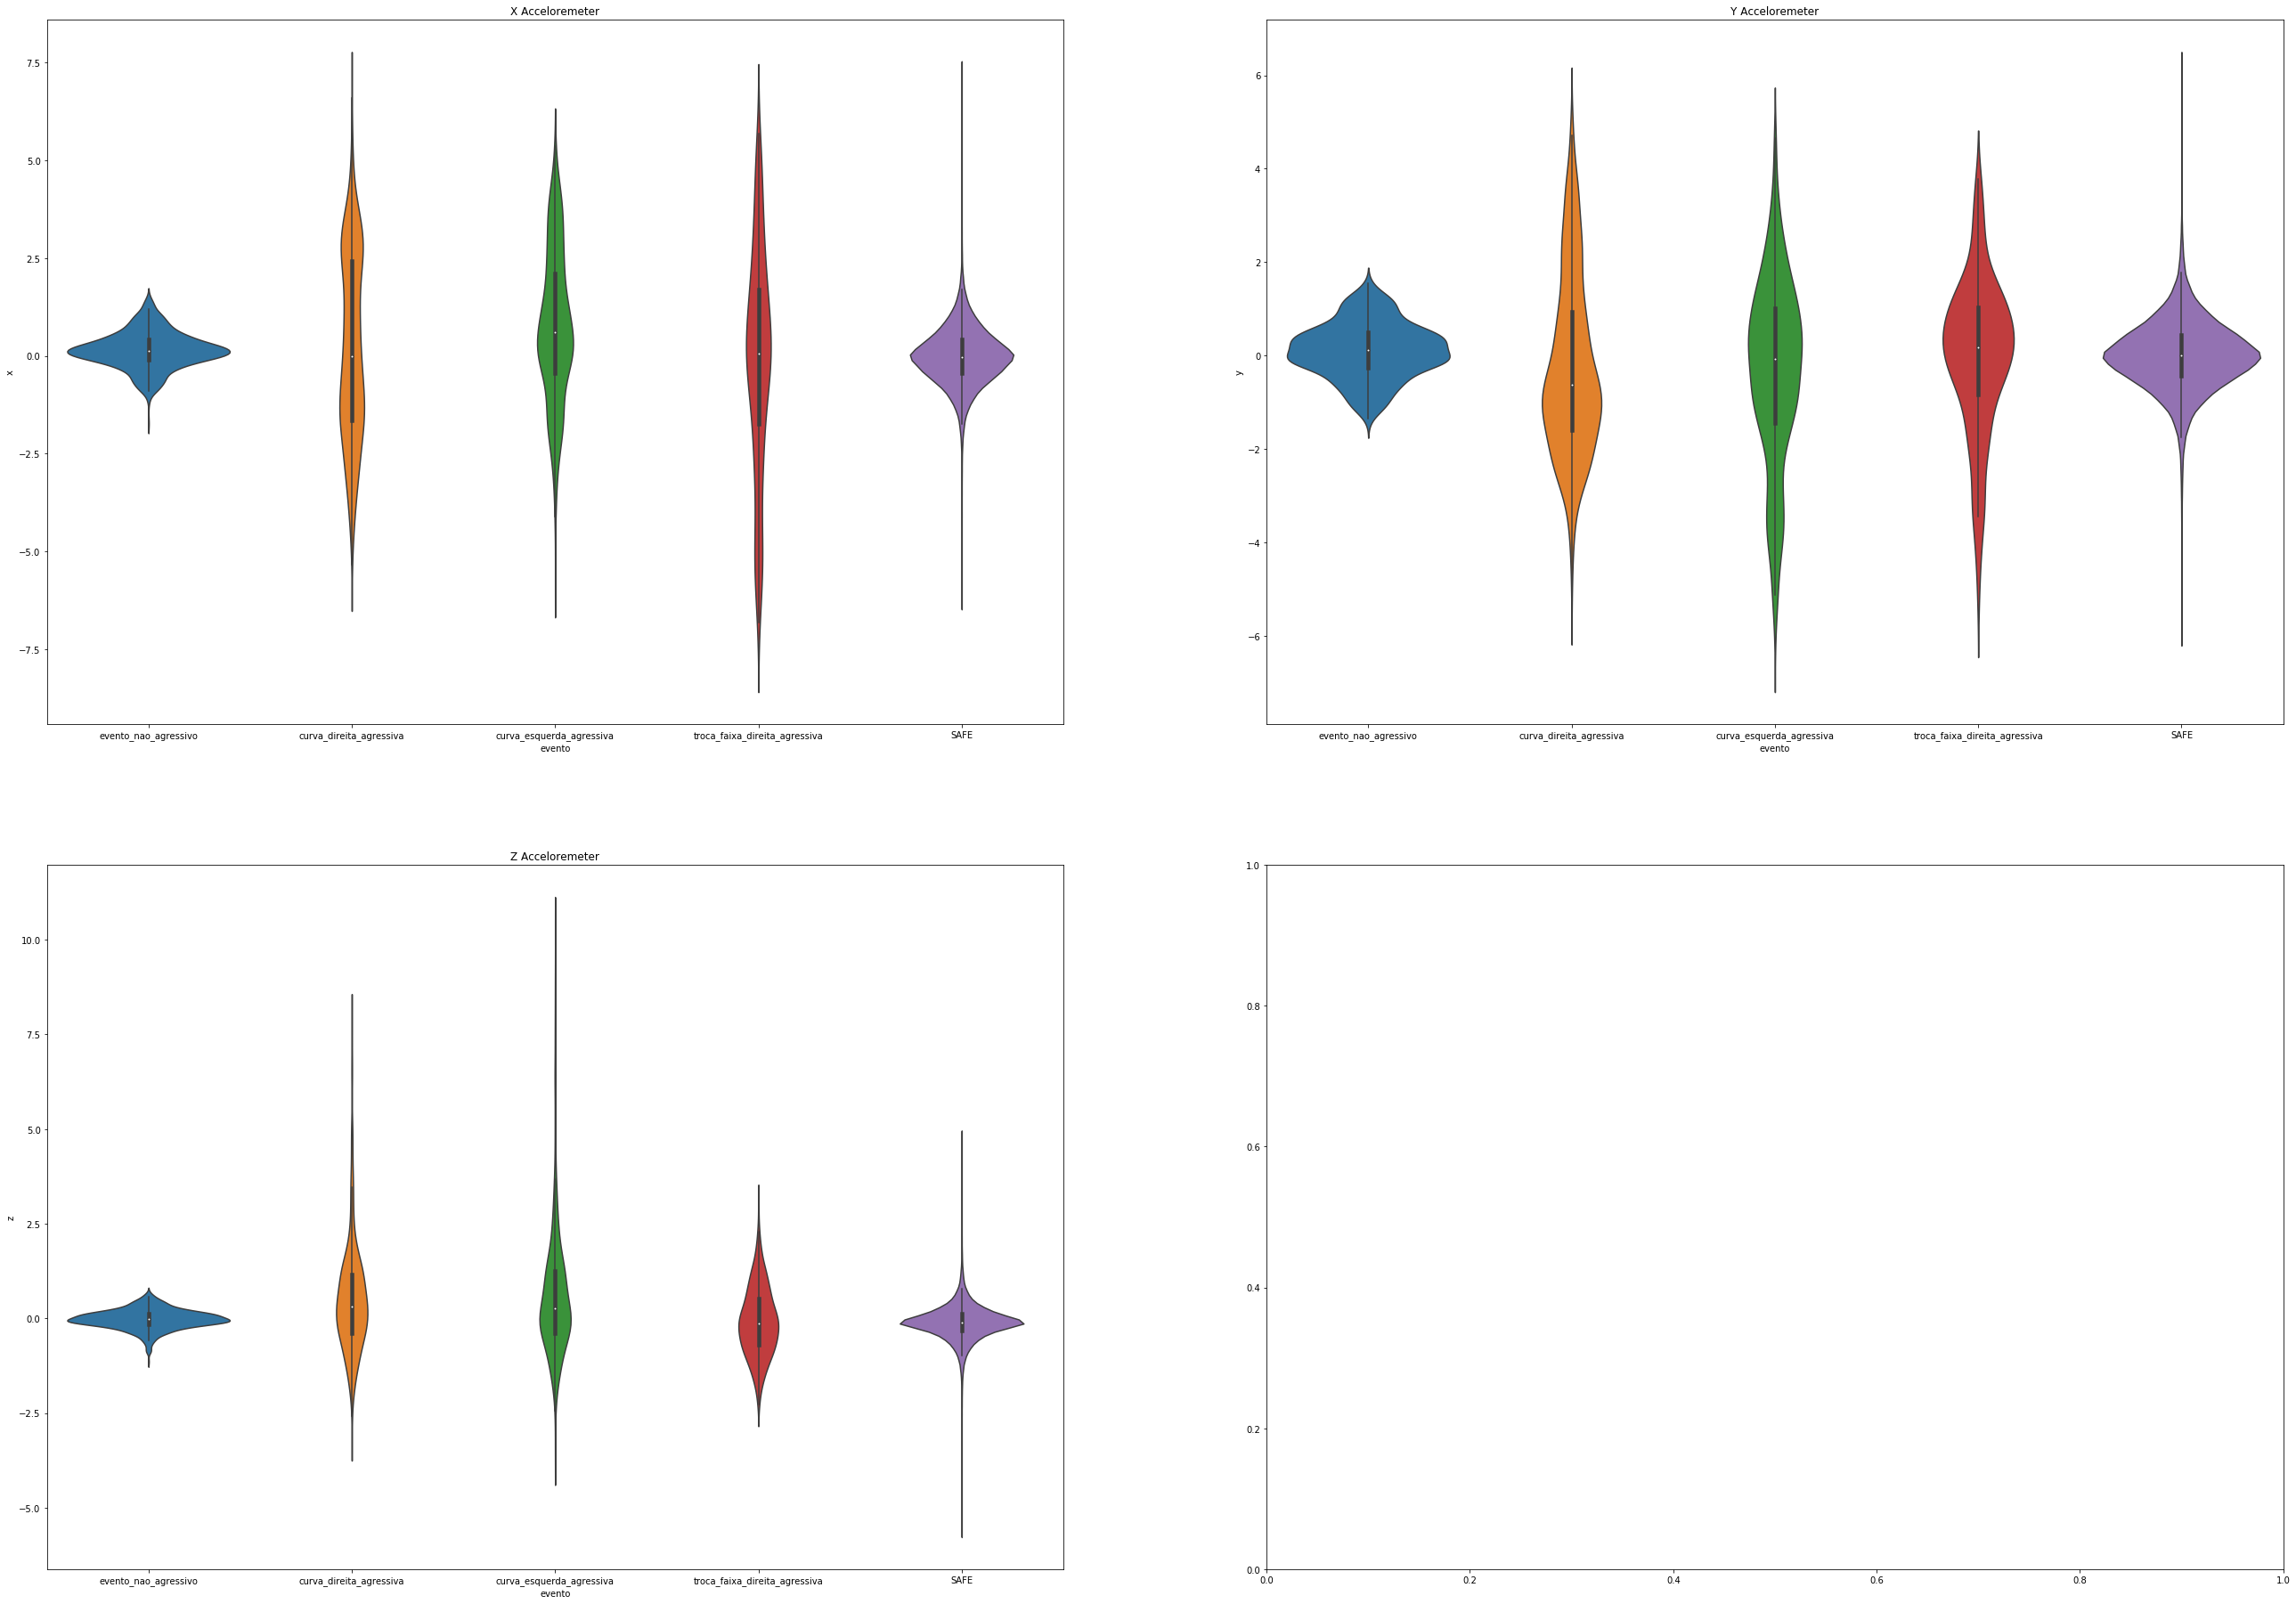

In [5]:
plot_violin(combo)

In [6]:
data16metro = read_in()[1]
raw,ground = process_in(data16metro,groundtruth)
danger,safe = outer_processing(raw,ground)
safe["evento"] = "SAFE"
combo = pd.concat([danger,safe], keys=['evento','x', 'y', 'z'])

NameError: name 'groundtruth' is not defined

In [ ]:
plot_violin(combo)

In [7]:
datamagnet = read_in()[3]
raw,ground = process_in(datamagnet,groundtruth)
danger,safe = outer_processing(raw,ground)
safe["evento"] = "SAFE"
combo = pd.concat([danger,safe], keys=['evento','x', 'y', 'z'])

NameError: name 'groundtruth' is not defined

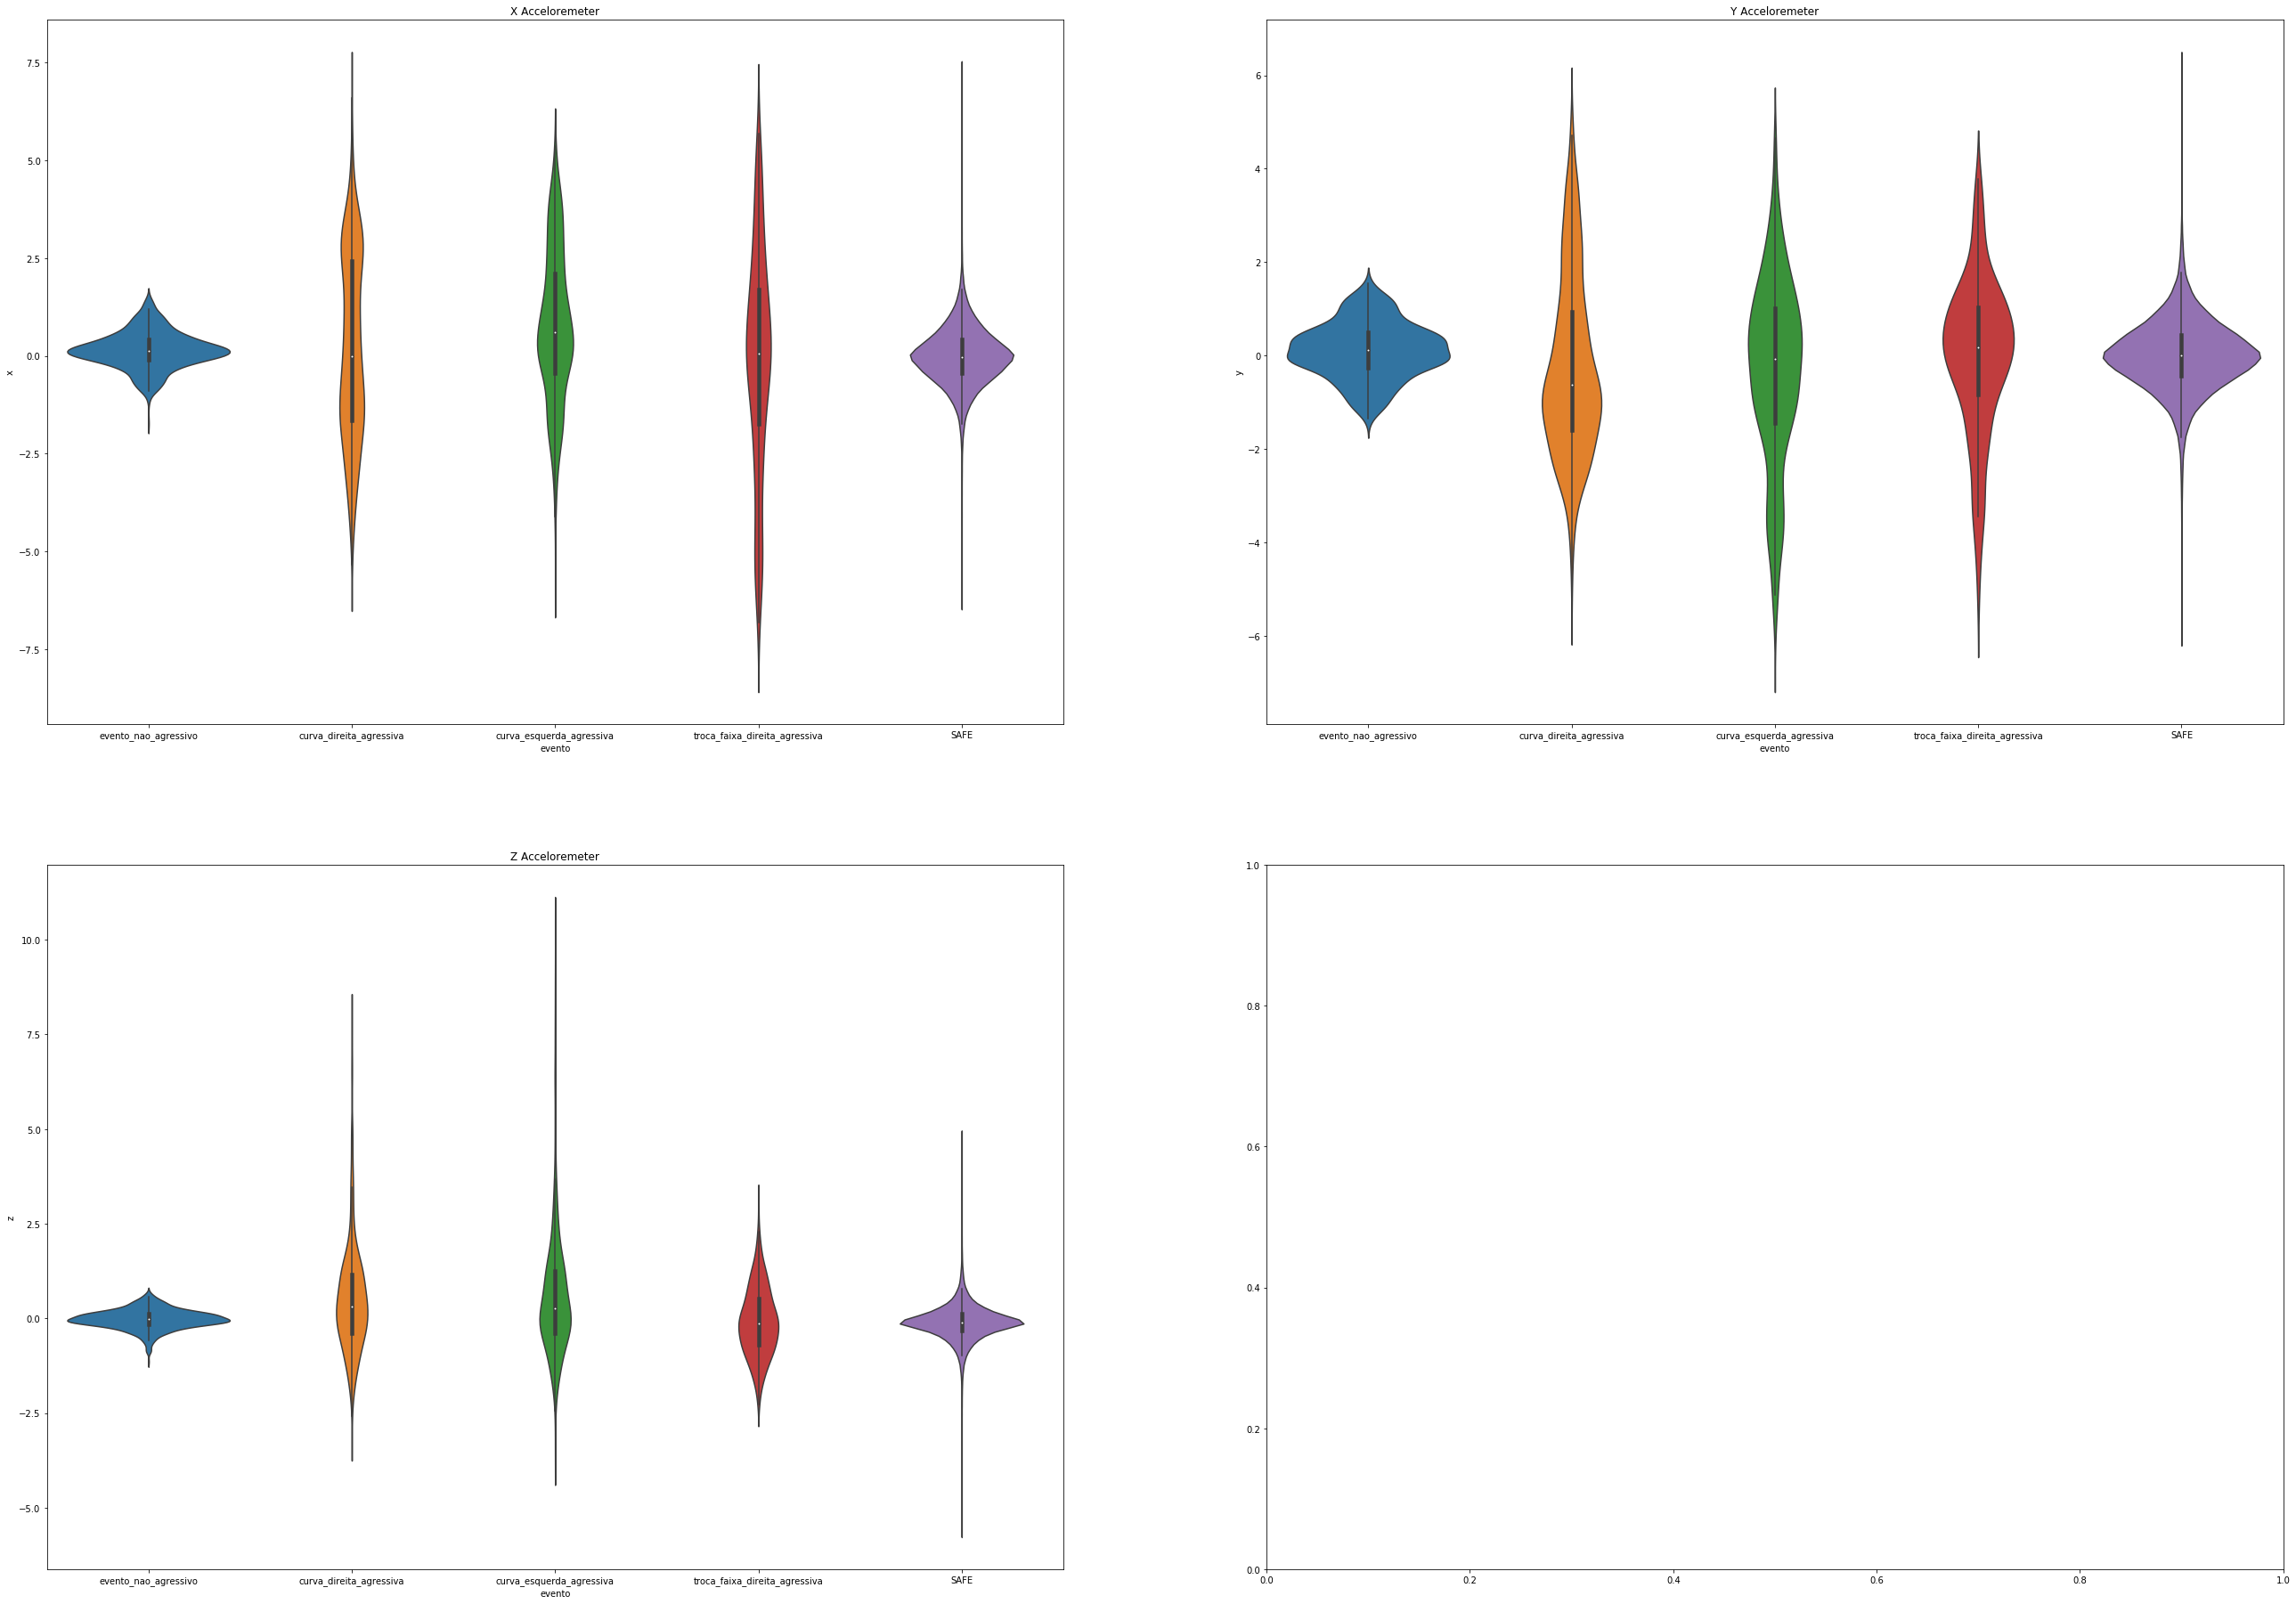

In [8]:
plot_violin(combo)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


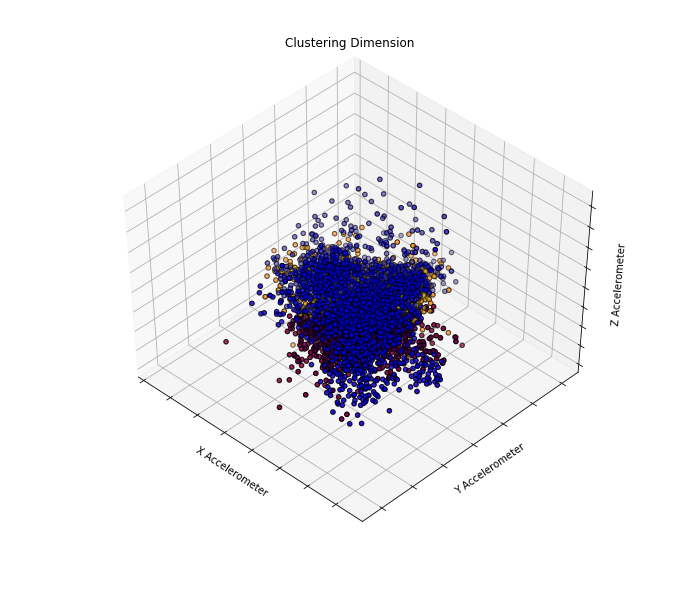

In [9]:
def k_means(x,y,z,label):
    est = KMeans(n_clusters=2)
    fig = plt.pyplot.figure(1, figsize=(10, 8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(pd.concat([x,y,z],axis=1))
    labels = est.labels_
    ax.scatter(x, y, z,
               c=labels.astype(np.float), edgecolor='k')
    ax.scatter(x[label == "SAFE"], y[label == "SAFE"], z[label == "SAFE"],
               c="r", edgecolor='k')
    ax.scatter(x[label != "SAFE"],  y[label != "SAFE"],  z[label != "SAFE"],
               c="b", edgecolor='k')
    
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('X Accelerometer')
    ax.set_ylabel('Y Accelerometer')
    ax.set_zlabel('Z Accelerometer')
    ax.set_title("Clustering Dimension")
    ax.dist = 12
    fig.show()
    
k_means(combo["x"],combo["y"],combo["z"],combo["evento"])

In [10]:
def group_danger(switch):
    switch['evento']=np.where(switch['evento'] =='evento_nao_agressivo', "danger", switch['evento'])
    switch['evento']=np.where(switch['evento'] =='curva_direita_agressiva', "danger", switch['evento'])
    switch['evento']=np.where(switch['evento'] =='curva_esquerda_agressiva', "danger", switch['evento'])
    switch['evento']=np.where(switch['evento'] =='troca_faixa_direita_agressiva', "danger", switch['evento'])
    switch["label"] = switch.evento.map({'danger': 1, 'SAFE': 0})
    return switch

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def run_logistic(combo):
    data_matrix = combo.iloc[:,:-1]
    labels = combo["label"]
    X_train, X_test, y_train, y_test = train_test_split(data_matrix, labels, test_size=0.3, random_state=0)
    print(np.sum(y_test))
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.pyplot.figure()
    plt.pyplot.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.pyplot.plot([0, 1], [0, 1],'r--')
    plt.pyplot.xlim([0.0, 1.0])
    plt.pyplot.ylim([0.0, 1.05])
    plt.pyplot.xlabel('False Positive Rate')
    plt.pyplot.ylabel('True Positive Rate')
    plt.pyplot.title('Receiver operating characteristic')
    plt.pyplot.legend(loc="lower right")
    plt.pyplot.savefig('Log_ROC')
    plt.pyplot.show()
    y_pred = logreg.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print(conf_matrix)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


In [15]:
data16metro = read_in()[1]
raw,ground = process_in(data16metro,groundtruth)
danger,safe = outer_processing(raw,ground)
safe["evento"] = "SAFE"
combo = pd.concat([danger,safe], keys=['evento','x', 'y', 'z'])

NameError: name 'groundtruth' is not defined

Index(['timestamp', 'uptimeNanos', 'x', 'y', 'z', 'dummy', 'evento', ' inicio',
       ' fim', 'end'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarnin

1823


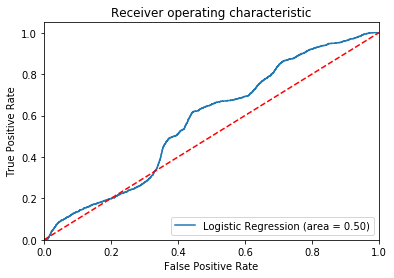

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     36864
           1       0.00      0.00      0.00      1823

    accuracy                           0.95     38687
   macro avg       0.48      0.50      0.49     38687
weighted avg       0.91      0.95      0.93     38687

[[36864     0]
 [ 1823     0]]
Accuracy of logistic regression classifier on test set: 0.95


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
def process_all_features():
    def combo(data,groundtruth):
        raw,ground = process_in(data,groundtruth)
        danger,safe = outer_processing(raw,ground)
        safe["evento"] = "SAFE"
        return pd.concat([danger,safe], keys=['evento','x', 'y', 'z'])
    data16accel,data16metro,ground_truth,campomagnetico = read_in()
    # technically we're losing campomagnetico info here
    result = combo(campomagnetico,ground_truth)
    final_data = group_danger(result)
    final_data = final_data.loc[:,["x","y","z","label"]]
    return final_data

data_matrix = process_all_features()
run_logistic(data_matrix)


x          y          z
evento 2272   -2.645247e-07  41.133434  -8.287663
       2288    3.107998e-07  41.135318  -8.278295
       2304   -1.094304e-08  41.042234  -8.415723
       2320    5.888869e-07  41.041479  -8.419361
       2336    9.805808e-07  40.779543  -8.515247
       2352   -7.283234e-08  40.780413  -8.511080
       2368   -7.387716e-07  40.969019  -8.421063
       2384    6.199116e-07  40.969526  -8.418594
       2400    6.134505e-07  40.686877  -8.455033
       2416    2.865563e-07  40.687166  -8.453682
       2432    1.646113e-07  40.679977  -8.697985
       2448    3.654277e-07  40.680942  -8.693469
       2464   -4.901667e-07  40.605059  -8.635781
       2480   -3.368623e-07  40.604034  -8.640594
       2496   -7.407943e-07  40.709519  -8.872188
       2512    3.173773e-08  40.709879  -8.870505
       2528    3.175810e-07  40.750691  -8.798420
       2544   -6.130722e-07  40.749073  -8.805932
       2560   -3.505847e-07  40.800994  -8.682428
       2576   -5.328038e-07  40.803542  -8.670439
       2592   -6.800110e-07  40.999372  -8.642671
       2608    8.994248e-07  41.000748  -8.636143
       2624   -2.887100e-07  40.970488  -8.835155
       2640    2.011075e-07  40.972948  -8.823735
       2656   -9.872019e-08  41.105159  -8.993859
       2672   -4.672620e-08  41.106226  -8.988963
       2688   -5.292968e-07  41.028406  -8.880845
       2704   -1.269509e-07  41.030218  -8.872439
       2720   -2.480228e-07  41.024062  -9.308874
       2736   -4.114700e-07  41.025695  -9.301666
...                     ...        ...        ...
x      128926 -5.885959e-07  15.026718 -10.747753
       128927  4.325993e-07  15.027370 -10.746837
       128928 -1.024455e-07  15.008957 -10.795543
       128929  1.601875e-07  15.009490 -10.794800
       128930 -3.669411e-07  15.090547 -10.798312
       128931 -1.545995e-07  15.091079 -10.797566
       128932  1.238659e-07  14.885216 -10.657886
       128933 -3.129244e-07  14.885056 -10.658107
       128934 -6.193295e-08  15.065461 -10.751120
       128935  5.806796e-07  15.067228 -10.748643
       128936 -4.302710e-07  15.272489 -10.456249
       128937  8.475035e-08  15.274933 -10.452676
       128938  3.301539e-07  15.161663 -10.625315
       128939  3.324822e-07  15.160256 -10.627326
       128940 -6.705523e-08  15.100910 -10.812752
       128941 -9.499490e-08  15.101818 -10.811484
       128942 -7.208437e-07  15.139521 -10.802288
       128943 -2.384186e-07  15.137528 -10.805080
       128944 -3.413297e-07  15.309775 -10.759147
       128945  1.089647e-07  15.305543 -10.765167
       128946 -1.979060e-07  15.257443 -10.409558
       128947 -4.358590e-07  15.239002 -10.436532
       128948  2.235174e-08  15.515367 -10.662063
       128949  1.564622e-07  15.507379 -10.673678
       128950  4.051253e-07  15.243100 -10.490298
       128951 -1.117587e-08  15.251873 -10.477536
       128952 -1.117587e-08  15.045683 -10.811708
       128953 -4.228204e-07  15.057556 -10.795168
       128954 -4.479662e-07  15.153189 -10.435536
       128955  2.672896e-07  15.156427 -10.430830

[128956 rows x 3 columns]